# Init

> From Google: https://google.github.io/mediapipe/solutions/pose_classification.html

In [1]:
# preprocessing 
import csv
import cv2
import numpy as np
import pandas as pd
import os
import sys
import keras
from tqdm.notebook import tqdm
from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose
import vg
import itertools

# network
from keras.utils import *
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
import sklearn
import matplotlib.pyplot as plt

2022-06-21 13:22:25.997968: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dacruon/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-21 13:22:25.997984: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Folder containing the dataset
images_in_folder = "referee_dataset"

# Folder containing the pictures with skeleton on top
images_out_folder = "referee_data_out_basic"

# output csv data
csv_out_path = "referee_data_out.csv"

# check if dataset is in directory
assert os.path.exists("referee_dataset"), "No dataset in directory"

# make dirs if they do not exist
os.makedirs(images_out_folder, exist_ok=True)

# Fetch landmarks

> This function runs blaze pose on the dataset, storing the x y and z coords in a csv file.

In [3]:
def get_landmarks():
    if os.path.exists(csv_out_path):
        return
    with open(csv_out_path, "w", newline="") as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)

        # Folder names are used as pose class names.
        pose_class_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        
        for pose_class_name in tqdm(pose_class_names, desc="Bootstrapping\t"):
            if not os.path.exists(os.path.join(images_out_folder, pose_class_name)):
                os.makedirs(os.path.join(images_out_folder, pose_class_name))

            image_names = sorted([
                n for n in os.listdir(os.path.join(images_in_folder, pose_class_name))
                if not n.startswith('.')])
            for image_name in tqdm(image_names, leave=False , desc=pose_class_name+"\t"):
                input_frame = cv2.imread(os.path.join(images_in_folder, pose_class_name, image_name))
                input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

                # Initialize fresh pose tracker and run it.
                with mp_pose.Pose() as pose_tracker:
                    result = pose_tracker.process(image=input_frame)
                    pose_landmarks = result.pose_landmarks

                # Save image with pose prediction (if pose was detected).
                output_frame = input_frame.copy()
                if pose_landmarks is not None:
                    mp_drawing.draw_landmarks(
                        image=output_frame,
                        landmark_list=pose_landmarks,
                        connections=mp_pose.POSE_CONNECTIONS)
                output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
                cv2.imwrite(os.path.join(images_out_folder, pose_class_name, image_name), output_frame)

                # Save landmarks.
                if pose_landmarks is not None:
                    # Check the number of landmarks and take pose landmarks.
                    assert len(pose_landmarks.landmark) == 33, 'Unexpected number of predicted pose landmarks: {}'.format(len(pose_landmarks.landmark))
                    pose_landmarks = [[lmk.x, lmk.y, lmk.z] for lmk in pose_landmarks.landmark]

                    # Map pose landmarks from [0, 1] range to absolute coordinates to get
                    # correct aspect ratio.
                    frame_height, frame_width = output_frame.shape[:2]
                    pose_landmarks *= np.array([frame_width, frame_height, frame_width])

                    # Write pose sample to CSV.
                    pose_landmarks = np.around(pose_landmarks, 5).flatten().astype(str).tolist()
                    csv_out_writer.writerow([image_name, pose_class_name] + pose_landmarks)
                
get_landmarks()

# Featurizers

> While these landmarks can already work pretty well as features, I also tested some additional preprocessing.

In [4]:
def get_position(data, i):
    return data[i+2:i+5]

def normalise(vector):
    return vector / np.linalg.norm(vector)

def get_angle(data, a, b, c):
    line_1 = get_position(data, a) - get_position(data, b)
    line_2 = get_position(data, c) - get_position(data, b)
    return vg.angle(line_1.astype(float), line_2.astype(float))

def distance(p1, p2):
    return np.sqrt(np.sum((p1-p2)**2, axis=0))

In [5]:
# distance based features
def get_embedding_v1(data):
    # restack data in 3d vectors & exclude face landmarks
    data = np.reshape(data, (-1, 3))[11:]
    
    # anchor all distances on left hip (origin)
    embedding = np.array([vector - data[23-11] for vector in data])
    
    # normalise with hips distance
    hip_distance = distance(embedding[23-11], embedding[24-11])
    embedding = np.array([vector / hip_distance for vector in embedding])
    
    return embedding.flatten()

# angle based features
def get_embedding_v2(data):
    embedding = np.array([get_angle(data, 13, 11, 23),
                          get_angle(data, 15, 13, 11),
                          get_angle(data, 17, 15, 13),
                          get_angle(data, 14, 12, 24),
                          get_angle(data, 16, 14, 12),
                          get_angle(data, 18, 16, 14),
                         ])
    return embedding

# vector based features
def get_embedding_v3(data):
    embedding = np.array([normalise(get_position(data, 13) - get_position(data, 11)),
                          normalise(get_position(data, 15) - get_position(data, 13)),
                          normalise(get_position(data, 17) - get_position(data, 15)),
                          normalise(get_position(data, 14) - get_position(data, 12)),
                          normalise(get_position(data, 16) - get_position(data, 14)),
                          normalise(get_position(data, 18) - get_position(data, 16)),
    ])
    return embedding.flatten()

# distance based features
def get_embedding_v4(data):
    # restack data in 3d vectors & exclude face landmarks
    data = np.reshape(data, (-1, 3))[11:]
    
    # get all distance combinations
    embedding = np.array([distance(p1, p2) for p1, p2 in itertools.combinations(data, 2)])
    
    # normalise with hips distance
    embedding /= embedding[0]
    return embedding

In [6]:
# processes single feature row
def embedder(version, feature_array):
    if version == 0:
        return feature_array
    if version == 1:
        return get_embedding_v1(feature_array)
    elif version  == 2:
        return get_embedding_v2(feature_array)
    elif version  == 3:
        return get_embedding_v2(feature_array)

# Builds feature csv from landmark data
def featurizer(version):
    # return features csv if it already exist
    feature_csv_name = "pose_features_"+ str(version) + ".csv"
    if os.path.exists(feature_csv_name):
        return pd.read_csv(feature_csv_name, index_col=0, header=None)
    
    # load feature data & return dataframe if version = 0
    landmark_data = pd.read_csv("referee_data_out.csv", index_col=0, header=None)
    if version == 0:
        return landmark_data
    
    # write feature csv
    with open(feature_csv_name, "w", newline="") as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        
        for row in landmark_data.iterrows():
            embedding = embedder(version, np.array(row[1])[1:])
            csv_out_writer.writerow(np.append([row[0], row[1][1]], embedding))       
    return pd.read_csv(feature_csv_name, index_col=0, header=None)

# Model

In [7]:
# Randomise and split dataframe into X and Y
def feature_target_split(df, shuffle=True):
    if shuffle:
        df = df.sample(frac = 1)
    
    dataset = df.values
    X = dataset[:,1:].astype(float)
    
    Y = dataset[:,0]
    encoder = sklearn.preprocessing.LabelEncoder()
    encoder.fit(Y)
    Y = to_categorical(encoder.transform(Y))
    return X, Y

def kfold_index(df, k=5):
    N = len(df)
    minimum_number_of_points_per_slice = N // k
    remaining_number_of_points = N % k
    starting_point = 0
    out = []
    for islice in range(0, k):
        end_point = starting_point + minimum_number_of_points_per_slice + ( islice < remaining_number_of_points )
        out.append((starting_point, end_point))
        starting_point = end_point
    return out

In [8]:
mass_data = pd.read_csv("referee_data_out.csv", index_col=0, header=None)
label_count = len(mass_data[1].unique())
id_to_pose = [pose for pose in mass_data[1].unique()]

def two_layer_integrated(X):
    inputs = Input(shape= (X.shape[1]-1,))
    layer = Dense(256, activation="relu")(inputs)
    outputs = Dense(label_count, activation="sigmoid")(layer)
    model = Model(inputs, outputs)
    model.compile(loss = "binary_crossentropy",optimizer = "adam",metrics = ["acc"])
    mc = ModelCheckpoint("best_pose_model.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    return model, mc

In [9]:
from sklearn.model_selection import train_test_split

def train(version, plot=True):
    mass_data = featurizer(version)
    
    # train test split
    X, Y = feature_target_split(mass_data)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, 
                                                        random_state=12, shuffle=True)
    
    # model training
    model, model_checkpoint = two_layer_integrated(mass_data)
    history = model.fit(X_train, Y_train ,epochs=500, callbacks=[model_checkpoint], batch_size=32, 
                        validation_data=(X_test, Y_test))

    # load the best model weights
    model.load_weights('best_pose_model.hdf5')
    
    # save model
    model.save("pose_model_" + str(version) + ".h5")

    # summarize history for loss
    if plot:
        plt.plot(history.history["acc"])
        plt.plot(history.history["val_acc"])
        plt.title("model accuracy")
        plt.ylabel("accuracy")
        plt.xlabel("epoch")
        plt.legend(["train", "val"], loc="upper left")
        plt.show()
        
    return model

# Detect

> source: https://www.youtube.com/watch?v=06TE_U21FK4

Epoch 1/500
 1/36 [..............................] - ETA: 8s - loss: 330.5668 - acc: 0.1875
Epoch 1: val_loss improved from inf to 8.96896, saving model to best_pose_model.hdf5
36/36 [==============================] - 0s 4ms/step - loss: 51.9494 - acc: 0.2744 - val_loss: 8.9690 - val_acc: 0.5106
Epoch 2/500
 1/36 [..............................] - ETA: 0s - loss: 10.3018 - acc: 0.5000
Epoch 2: val_loss improved from 8.96896 to 4.08307, saving model to best_pose_model.hdf5
36/36 [==============================] - 0s 2ms/step - loss: 6.9520 - acc: 0.5497 - val_loss: 4.0831 - val_acc: 0.6064
Epoch 3/500
 1/36 [..............................] - ETA: 0s - loss: 5.2999 - acc: 0.5625
Epoch 3: val_loss improved from 4.08307 to 3.41861, saving model to best_pose_model.hdf5
36/36 [==============================] - 0s 2ms/step - loss: 3.8779 - acc: 0.6883 - val_loss: 3.4186 - val_acc: 0.6773
Epoch 4/500
 1/36 [..............................] - ETA: 0s - loss: 3.8668 - acc: 0.6875
Epoch 4: val_los

36/36 [==============================] - 0s 2ms/step - loss: 0.5036 - acc: 0.9583 - val_loss: 0.8136 - val_acc: 0.9468
Epoch 32/500
 1/36 [..............................] - ETA: 0s - loss: 0.6071 - acc: 0.9688
Epoch 32: val_loss improved from 0.42947 to 0.37970, saving model to best_pose_model.hdf5
36/36 [==============================] - 0s 2ms/step - loss: 0.9433 - acc: 0.9307 - val_loss: 0.3797 - val_acc: 0.9645
Epoch 33/500
 1/36 [..............................] - ETA: 0s - loss: 0.2097 - acc: 0.9375
Epoch 33: val_loss did not improve from 0.37970
36/36 [==============================] - 0s 2ms/step - loss: 1.5741 - acc: 0.8890 - val_loss: 1.4216 - val_acc: 0.9220
Epoch 34/500
 1/36 [..............................] - ETA: 0s - loss: 0.9863 - acc: 0.8750
Epoch 34: val_loss did not improve from 0.37970
36/36 [==============================] - 0s 2ms/step - loss: 1.2113 - acc: 0.9236 - val_loss: 3.2034 - val_acc: 0.8830
Epoch 35/500
 1/36 [..............................] - ETA: 0s - l

 1/36 [..............................] - ETA: 0s - loss: 0.6218 - acc: 1.0000
Epoch 63: val_loss did not improve from 0.37970
36/36 [==============================] - 0s 2ms/step - loss: 0.4111 - acc: 0.9663 - val_loss: 0.4529 - val_acc: 0.9504
Epoch 64/500
 1/36 [..............................] - ETA: 0s - loss: 0.4400 - acc: 0.9375
Epoch 64: val_loss did not improve from 0.37970
36/36 [==============================] - 0s 2ms/step - loss: 0.3506 - acc: 0.9716 - val_loss: 0.6520 - val_acc: 0.9716
Epoch 65/500
 1/36 [..............................] - ETA: 0s - loss: 0.4755 - acc: 1.0000
Epoch 65: val_loss did not improve from 0.37970
36/36 [==============================] - 0s 2ms/step - loss: 0.4262 - acc: 0.9725 - val_loss: 0.7180 - val_acc: 0.9291
Epoch 66/500
 1/36 [..............................] - ETA: 0s - loss: 0.9131 - acc: 0.9062
Epoch 66: val_loss did not improve from 0.37970
36/36 [==============================] - 0s 2ms/step - loss: 0.3775 - acc: 0.9698 - val_loss: 0.4507

 1/36 [..............................] - ETA: 0s - loss: 0.9115 - acc: 0.9062
Epoch 94: val_loss did not improve from 0.16147
36/36 [==============================] - 0s 2ms/step - loss: 0.4799 - acc: 0.9707 - val_loss: 0.5222 - val_acc: 0.9504
Epoch 95/500
 1/36 [..............................] - ETA: 0s - loss: 0.2163 - acc: 1.0000
Epoch 95: val_loss did not improve from 0.16147
36/36 [==============================] - 0s 2ms/step - loss: 0.3858 - acc: 0.9787 - val_loss: 0.5625 - val_acc: 0.9539
Epoch 96/500
 1/36 [..............................] - ETA: 0s - loss: 0.0970 - acc: 1.0000
Epoch 96: val_loss did not improve from 0.16147
36/36 [==============================] - 0s 2ms/step - loss: 0.2926 - acc: 0.9751 - val_loss: 0.5145 - val_acc: 0.9362
Epoch 97/500
 1/36 [..............................] - ETA: 0s - loss: 0.3576 - acc: 1.0000
Epoch 97: val_loss did not improve from 0.16147
36/36 [==============================] - 0s 2ms/step - loss: 0.5673 - acc: 0.9583 - val_loss: 0.2043

Epoch 126/500
 1/36 [..............................] - ETA: 0s - loss: 3.6428e-07 - acc: 1.0000
Epoch 126: val_loss did not improve from 0.16147
36/36 [==============================] - 0s 2ms/step - loss: 0.2078 - acc: 0.9885 - val_loss: 0.3975 - val_acc: 0.9716
Epoch 127/500
 1/36 [..............................] - ETA: 0s - loss: 0.1260 - acc: 1.0000
Epoch 127: val_loss did not improve from 0.16147
36/36 [==============================] - 0s 2ms/step - loss: 0.1570 - acc: 0.9876 - val_loss: 0.3895 - val_acc: 0.9681
Epoch 128/500
 1/36 [..............................] - ETA: 0s - loss: 0.1361 - acc: 1.0000
Epoch 128: val_loss did not improve from 0.16147
36/36 [==============================] - 0s 2ms/step - loss: 0.2237 - acc: 0.9822 - val_loss: 0.2662 - val_acc: 0.9752
Epoch 129/500
 1/36 [..............................] - ETA: 0s - loss: 0.0331 - acc: 1.0000
Epoch 129: val_loss improved from 0.16147 to 0.15468, saving model to best_pose_model.hdf5
36/36 [==========================

 1/36 [..............................] - ETA: 0s - loss: 0.0416 - acc: 1.0000
Epoch 157: val_loss did not improve from 0.15468
36/36 [==============================] - 0s 2ms/step - loss: 0.0646 - acc: 0.9964 - val_loss: 0.2023 - val_acc: 0.9752
Epoch 158/500
 1/36 [..............................] - ETA: 0s - loss: 0.0082 - acc: 1.0000
Epoch 158: val_loss did not improve from 0.15468
36/36 [==============================] - 0s 2ms/step - loss: 0.0831 - acc: 0.9938 - val_loss: 0.2015 - val_acc: 0.9752
Epoch 159/500
 1/36 [..............................] - ETA: 0s - loss: 1.1727e-09 - acc: 1.0000
Epoch 159: val_loss did not improve from 0.15468
36/36 [==============================] - 0s 2ms/step - loss: 0.0596 - acc: 0.9929 - val_loss: 0.2301 - val_acc: 0.9716
Epoch 160/500
 1/36 [..............................] - ETA: 0s - loss: 0.0038 - acc: 1.0000
Epoch 160: val_loss did not improve from 0.15468
36/36 [==============================] - 0s 2ms/step - loss: 0.1599 - acc: 0.9893 - val_l

 1/36 [..............................] - ETA: 0s - loss: 0.1935 - acc: 1.0000
Epoch 188: val_loss did not improve from 0.13819
36/36 [==============================] - 0s 2ms/step - loss: 0.0844 - acc: 0.9893 - val_loss: 0.1519 - val_acc: 0.9823
Epoch 189/500
 1/36 [..............................] - ETA: 0s - loss: 0.0620 - acc: 1.0000
Epoch 189: val_loss did not improve from 0.13819
36/36 [==============================] - 0s 2ms/step - loss: 0.1557 - acc: 0.9831 - val_loss: 0.3692 - val_acc: 0.9716
Epoch 190/500
 1/36 [..............................] - ETA: 0s - loss: 0.1475 - acc: 1.0000
Epoch 190: val_loss did not improve from 0.13819
36/36 [==============================] - 0s 2ms/step - loss: 0.1629 - acc: 0.9831 - val_loss: 0.5442 - val_acc: 0.9504
Epoch 191/500
 1/36 [..............................] - ETA: 0s - loss: 0.3617 - acc: 0.9688
Epoch 191: val_loss did not improve from 0.13819
36/36 [==============================] - 0s 2ms/step - loss: 0.2994 - acc: 0.9707 - val_loss:

36/36 [==============================] - 0s 2ms/step - loss: 0.2693 - acc: 0.9725 - val_loss: 0.3386 - val_acc: 0.9574
Epoch 220/500
 1/36 [..............................] - ETA: 0s - loss: 0.1778 - acc: 1.0000
Epoch 220: val_loss did not improve from 0.13819
36/36 [==============================] - 0s 2ms/step - loss: 0.1596 - acc: 0.9822 - val_loss: 0.3582 - val_acc: 0.9539
Epoch 221/500
 1/36 [..............................] - ETA: 0s - loss: 0.2890 - acc: 0.9375
Epoch 221: val_loss did not improve from 0.13819
36/36 [==============================] - 0s 2ms/step - loss: 0.2630 - acc: 0.9707 - val_loss: 0.6612 - val_acc: 0.9433
Epoch 222/500
 1/36 [..............................] - ETA: 0s - loss: 0.1572 - acc: 0.9688
Epoch 222: val_loss did not improve from 0.13819
36/36 [==============================] - 0s 2ms/step - loss: 0.1254 - acc: 0.9796 - val_loss: 0.2063 - val_acc: 0.9787
Epoch 223/500
 1/36 [..............................] - ETA: 0s - loss: 0.1306 - acc: 1.0000
Epoch 223

36/36 [==============================] - 0s 2ms/step - loss: 0.1159 - acc: 0.9831 - val_loss: 0.1590 - val_acc: 0.9752
Epoch 251/500
 1/36 [..............................] - ETA: 0s - loss: 0.0342 - acc: 1.0000
Epoch 251: val_loss did not improve from 0.10929
36/36 [==============================] - 0s 2ms/step - loss: 0.1301 - acc: 0.9840 - val_loss: 0.2141 - val_acc: 0.9539
Epoch 252/500
 1/36 [..............................] - ETA: 0s - loss: 9.5969e-06 - acc: 1.0000
Epoch 252: val_loss did not improve from 0.10929
36/36 [==============================] - 0s 2ms/step - loss: 0.1666 - acc: 0.9760 - val_loss: 0.5875 - val_acc: 0.9149
Epoch 253/500
 1/36 [..............................] - ETA: 0s - loss: 0.6473 - acc: 0.9688
Epoch 253: val_loss did not improve from 0.10929
36/36 [==============================] - 0s 2ms/step - loss: 0.0487 - acc: 0.9911 - val_loss: 0.2399 - val_acc: 0.9858
Epoch 254/500
 1/36 [..............................] - ETA: 0s - loss: 2.4101e-12 - acc: 1.0000
E

36/36 [==============================] - 0s 2ms/step - loss: 0.0551 - acc: 0.9929 - val_loss: 0.1561 - val_acc: 0.9823
Epoch 282/500
 1/36 [..............................] - ETA: 0s - loss: 0.0935 - acc: 1.0000
Epoch 282: val_loss did not improve from 0.07357
36/36 [==============================] - 0s 2ms/step - loss: 0.0560 - acc: 0.9920 - val_loss: 0.1889 - val_acc: 0.9823
Epoch 283/500
 1/36 [..............................] - ETA: 0s - loss: 0.1129 - acc: 1.0000
Epoch 283: val_loss did not improve from 0.07357
36/36 [==============================] - 0s 2ms/step - loss: 0.0367 - acc: 0.9947 - val_loss: 0.1440 - val_acc: 0.9716
Epoch 284/500
 1/36 [..............................] - ETA: 0s - loss: 0.1046 - acc: 1.0000
Epoch 284: val_loss did not improve from 0.07357
36/36 [==============================] - 0s 2ms/step - loss: 0.0220 - acc: 0.9956 - val_loss: 0.0797 - val_acc: 0.9929
Epoch 285/500
 1/36 [..............................] - ETA: 0s - loss: 1.1897e-04 - acc: 1.0000
Epoch

36/36 [==============================] - 0s 2ms/step - loss: 0.0695 - acc: 0.9858 - val_loss: 0.3313 - val_acc: 0.9610
Epoch 313/500
 1/36 [..............................] - ETA: 0s - loss: 0.2432 - acc: 0.9688
Epoch 313: val_loss did not improve from 0.04975
36/36 [==============================] - 0s 2ms/step - loss: 0.0873 - acc: 0.9885 - val_loss: 0.1695 - val_acc: 0.9823
Epoch 314/500
 1/36 [..............................] - ETA: 0s - loss: 0.1002 - acc: 1.0000
Epoch 314: val_loss did not improve from 0.04975
36/36 [==============================] - 0s 2ms/step - loss: 0.0999 - acc: 0.9813 - val_loss: 0.2967 - val_acc: 0.9220
Epoch 315/500
 1/36 [..............................] - ETA: 0s - loss: 0.4002 - acc: 0.9375
Epoch 315: val_loss did not improve from 0.04975
36/36 [==============================] - 0s 2ms/step - loss: 0.1915 - acc: 0.9707 - val_loss: 0.2252 - val_acc: 0.9504
Epoch 316/500
 1/36 [..............................] - ETA: 0s - loss: 0.0733 - acc: 0.9688
Epoch 316

Epoch 344/500
 1/36 [..............................] - ETA: 0s - loss: 3.9600e-04 - acc: 1.0000
Epoch 344: val_loss did not improve from 0.02900
36/36 [==============================] - 0s 2ms/step - loss: 0.0376 - acc: 0.9893 - val_loss: 0.0874 - val_acc: 0.9716
Epoch 345/500
 1/36 [..............................] - ETA: 0s - loss: 0.0015 - acc: 1.0000
Epoch 345: val_loss did not improve from 0.02900
36/36 [==============================] - 0s 2ms/step - loss: 0.0256 - acc: 0.9964 - val_loss: 0.0413 - val_acc: 0.9929
Epoch 346/500
 1/36 [..............................] - ETA: 0s - loss: 0.0134 - acc: 1.0000
Epoch 346: val_loss did not improve from 0.02900
36/36 [==============================] - 0s 2ms/step - loss: 0.0130 - acc: 0.9956 - val_loss: 0.0611 - val_acc: 0.9894
Epoch 347/500
 1/36 [..............................] - ETA: 0s - loss: 7.8499e-05 - acc: 1.0000
Epoch 347: val_loss did not improve from 0.02900
36/36 [==============================] - 0s 2ms/step - loss: 0.0116 - a

 1/36 [..............................] - ETA: 0s - loss: 0.0112 - acc: 1.0000
Epoch 375: val_loss did not improve from 0.01722
36/36 [==============================] - 0s 2ms/step - loss: 0.0212 - acc: 0.9947 - val_loss: 0.0592 - val_acc: 0.9894
Epoch 376/500
 1/36 [..............................] - ETA: 0s - loss: 1.8022e-05 - acc: 1.0000
Epoch 376: val_loss did not improve from 0.01722
36/36 [==============================] - 0s 2ms/step - loss: 0.0239 - acc: 0.9876 - val_loss: 0.0463 - val_acc: 0.9823
Epoch 377/500
 1/36 [..............................] - ETA: 0s - loss: 0.0351 - acc: 1.0000
Epoch 377: val_loss did not improve from 0.01722
36/36 [==============================] - 0s 2ms/step - loss: 0.0321 - acc: 0.9876 - val_loss: 0.1001 - val_acc: 0.9787
Epoch 378/500
 1/36 [..............................] - ETA: 0s - loss: 3.9617e-06 - acc: 1.0000
Epoch 378: val_loss did not improve from 0.01722
36/36 [==============================] - 0s 2ms/step - loss: 0.0258 - acc: 0.9956 - v

36/36 [==============================] - 0s 2ms/step - loss: 0.0105 - acc: 0.9956 - val_loss: 0.0513 - val_acc: 0.9858
Epoch 407/500
 1/36 [..............................] - ETA: 0s - loss: 2.0910e-07 - acc: 1.0000
Epoch 407: val_loss did not improve from 0.01722
36/36 [==============================] - 0s 2ms/step - loss: 0.0252 - acc: 0.9902 - val_loss: 0.1146 - val_acc: 0.9504
Epoch 408/500
 1/36 [..............................] - ETA: 0s - loss: 0.0157 - acc: 1.0000
Epoch 408: val_loss did not improve from 0.01722
36/36 [==============================] - 0s 2ms/step - loss: 0.0361 - acc: 0.9849 - val_loss: 0.0512 - val_acc: 0.9858
Epoch 409/500
 1/36 [..............................] - ETA: 0s - loss: 3.1167e-06 - acc: 1.0000
Epoch 409: val_loss did not improve from 0.01722
36/36 [==============================] - 0s 2ms/step - loss: 0.0111 - acc: 0.9947 - val_loss: 0.0299 - val_acc: 0.9823
Epoch 410/500
 1/36 [..............................] - ETA: 0s - loss: 0.0142 - acc: 1.0000
E

Epoch 438/500
 1/36 [..............................] - ETA: 0s - loss: 1.8923e-06 - acc: 1.0000
Epoch 438: val_loss did not improve from 0.01722
36/36 [==============================] - 0s 2ms/step - loss: 0.0078 - acc: 0.9964 - val_loss: 0.0436 - val_acc: 0.9858
Epoch 439/500
 1/36 [..............................] - ETA: 0s - loss: 2.2994e-04 - acc: 1.0000
Epoch 439: val_loss did not improve from 0.01722
36/36 [==============================] - 0s 2ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0344 - val_acc: 0.9894
Epoch 440/500
 1/36 [..............................] - ETA: 0s - loss: 2.7881e-04 - acc: 1.0000
Epoch 440: val_loss did not improve from 0.01722
36/36 [==============================] - 0s 2ms/step - loss: 0.0023 - acc: 0.9982 - val_loss: 0.0299 - val_acc: 0.9858
Epoch 441/500
 1/36 [..............................] - ETA: 0s - loss: 1.8988e-04 - acc: 1.0000
Epoch 441: val_loss did not improve from 0.01722
36/36 [==============================] - 0s 2ms/step - loss: 0.

 1/36 [..............................] - ETA: 0s - loss: 0.0039 - acc: 1.0000
Epoch 469: val_loss did not improve from 0.01722
36/36 [==============================] - 0s 2ms/step - loss: 0.0047 - acc: 0.9982 - val_loss: 0.0341 - val_acc: 0.9929
Epoch 470/500
 1/36 [..............................] - ETA: 0s - loss: 7.4119e-05 - acc: 1.0000
Epoch 470: val_loss improved from 0.01722 to 0.01546, saving model to best_pose_model.hdf5
36/36 [==============================] - 0s 2ms/step - loss: 0.0066 - acc: 0.9973 - val_loss: 0.0155 - val_acc: 0.9929
Epoch 471/500
 1/36 [..............................] - ETA: 0s - loss: 9.3616e-04 - acc: 1.0000
Epoch 471: val_loss did not improve from 0.01546
36/36 [==============================] - 0s 2ms/step - loss: 0.0292 - acc: 0.9902 - val_loss: 0.0338 - val_acc: 0.9894
Epoch 472/500
 1/36 [..............................] - ETA: 0s - loss: 0.0031 - acc: 1.0000
Epoch 472: val_loss did not improve from 0.01546
36/36 [==============================] - 0s

 1/36 [..............................] - ETA: 0s - loss: 0.0220 - acc: 1.0000
Epoch 500: val_loss did not improve from 0.01546
36/36 [==============================] - 0s 2ms/step - loss: 0.0501 - acc: 0.9885 - val_loss: 0.0584 - val_acc: 0.9823


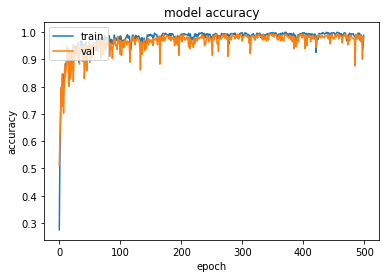

QObject::moveToThread: Current thread (0x558d5b208250) is not the object's thread (0x558d5ad28100).
Cannot move to target thread (0x558d5b208250)

QObject::moveToThread: Current thread (0x558d5b208250) is not the object's thread (0x558d5ad28100).
Cannot move to target thread (0x558d5b208250)

QObject::moveToThread: Current thread (0x558d5b208250) is not the object's thread (0x558d5ad28100).
Cannot move to target thread (0x558d5b208250)

QObject::moveToThread: Current thread (0x558d5b208250) is not the object's thread (0x558d5ad28100).
Cannot move to target thread (0x558d5b208250)

QObject::moveToThread: Current thread (0x558d5b208250) is not the object's thread (0x558d5ad28100).
Cannot move to target thread (0x558d5b208250)

QObject::moveToThread: Current thread (0x558d5b208250) is not the object's thread (0x558d5ad28100).
Cannot move to target thread (0x558d5b208250)

QObject::moveToThread: Current thread (0x558d5b208250) is not the object's thread (0x558d5ad28100).
Cannot move to tar

In [12]:
def detect_live(version):
    # load model
    try:
        model = keras.models.load_model("pose_model_" + str(version) + ".h5")
    except:
        model = train(version)

    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 3 * 200)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 4 * 200)
    ## Setup mediapipe instance
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()

            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make detection
            result = pose.process(image)
            pose_landmarks = result.pose_landmarks

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Render detections
            mp_drawing.draw_landmarks(image, result.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                      mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )            

            # Save landmarks.
            if pose_landmarks is not None:
                # Check the number of landmarks and take pose landmarks.
                assert len(pose_landmarks.landmark) == 33, 'Unexpected number of predicted pose landmarks: {}'.format(len(pose_landmarks.landmark))
                pose_landmarks = [[lmk.x, lmk.y, lmk.z] for lmk in pose_landmarks.landmark]
                frame_height, frame_width = image.shape[:2]
                pose_landmarks *= np.array([frame_width, frame_height, frame_width])
                #pose_landmarks = np.around(pose_landmarks, 5).flatten().astype(str).tolist()
                pose_landmarks = np.around(pose_landmarks, 5).flatten()

                # predicting
                features = embedder(version, pose_landmarks)
                #print(features)
                features = np.expand_dims(features, axis=0).astype(float)
                prediction_list = list(model.predict(features, verbose=0)[0])
                prediction_id = prediction_list.index(max(prediction_list))

                # show on screen
                font = cv2.FONT_HERSHEY_SIMPLEX
                text = 'Pose Id: ' + id_to_pose[prediction_id] + " " + str(round(max(prediction_list)*100)) + "%"
                cv2.putText(image, text, (50, 50), font, 1, (255, 0, 0),2, cv2.LINE_4)

            cv2.imshow('Mediapipe Feed', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        
detect_live(0)